# Double Duelin DQN Training

Setup Environment including the current directory

In [1]:
%matplotlib inline

import sys
from unityagents import UnityEnvironment
import numpy as np
import datetime
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
sys.path.append('')

In [3]:
from agents.double_ddqn import DoubleDDQNAgent

## Create the Traning Loop Function

In [12]:
def training_loop(agent, brain_name,episod_start=1,n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995,solved_score=13):
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(episod_start, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state =  env_info.vector_observations[0]
        
        score = 0
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done  = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
            if np.mean(scores_window) >= solved_score:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                break
    
    checkpoint_fn = f"checkpoint_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
    print(f'Saving checkpoint in: {checkpoint_fn}')
    
    state = {
        'episodes': i_episode +1,
        'current_eps': eps,
        'local_state_dict': agent.qnetwork_local.state_dict(),
        'target_state_dict': agent.qnetwork_target.state_dict(),
        'optimizer': agent.optimizer.state_dict() 
    }

    torch.save(state, checkpoint_fn)    
        
    return scores

## Create the Environment and run traning

To resume trading from checkpoint set the checkpoint_fn to the latest checkpoint file name and change:

- the number of epochs
- the desired score to consider the env solved (default 13)

__Note:__ If training does not start restart the Kernel and try again

In [5]:
env = UnityEnvironment(file_name="Banana.app")
#checkpoint_fn = 'checkpoint_20200503_154535.pth'
checkpoint_fn = None

if checkpoint_fn:
    checkpoint = torch.load(checkpoint_fn)
    episode_start = checkpoint['episodes']
    eps_start = checkpoint['current_eps']
    num_episodes = 1000
    solved_score = 16
else:
    checkpoint = None
    episode_start = 1
    eps_start = 1.0
    num_episodes = 1000
    solved_score = 14

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

state_size = brain.vector_observation_space_size
action_size = brain.vector_action_space_size
agent = DoubleDDQNAgent(state_size=state_size, action_size=action_size, seed=0,checkpoint=checkpoint)


scores = training_loop(agent,brain_name,episode_start,num_episodes,eps_start=eps_start,solved_score=solved_score)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.87
Episode 200	Average Score: 4.87
Episode 300	Average Score: 9.09
Episode 400	Average Score: 11.12
Episode 500	Average Score: 12.93
Episode 600	Average Score: 14.34

Environment solved in 500 episodes!	Average Score: 14.34
Saving checkpoint in: checkpoint_20200504_174604.pth


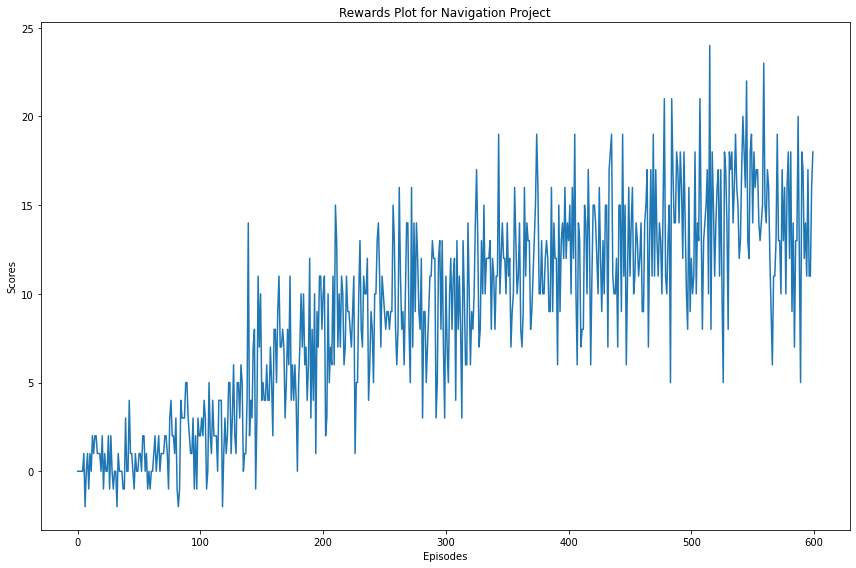

In [8]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(scores)
plt.xlabel('Episodes')
plt.ylabel('Scores')
plt.title('Rewards Plot for Navigation Project')
plt.tight_layout()
plt.savefig('./rewards_plot.eps',format='eps')
plt.show()

In [ ]:
env.close()

In [11]:
np.save('./scores.pkl',np.array(scores))